# Data visualization (Part 2) - Power BI

Power BI is a data visualization and analysis tool. Just like in Kibana, we can create visualization dashboards to present data in real time, plus giving the possiblity of drilling down into the plots for data visualization. 

In this lab we will cover how we can query data with DAX and the most basic form of visuatlization, the table. 

## Requirements
* Power BI desktop (<https://www.microsoft.com/es-es/download/details.aspx?id=58494>)
* Power BI is only compatible with Windows. If using a different OS, consider using a Virtual Machine (<https://developer.microsoft.com/en-us/windows/downloads/virtual-machines/>)

## Loading the data

Start by adding the data:
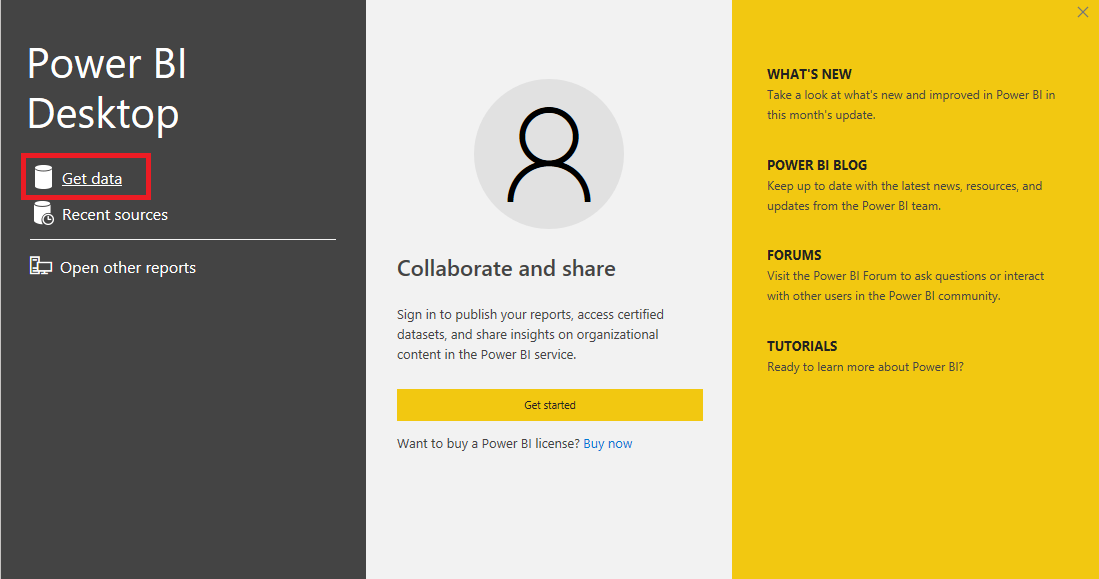

Data can be loaded from a local file or a DB. Some DBs are listed by name, like Postgres, others rely on ODBC standard controller, like MongoDB. 




### Add a data source
First, we will be connecting to the Postgres DB we set up in the SQL lab with the Office dataset.

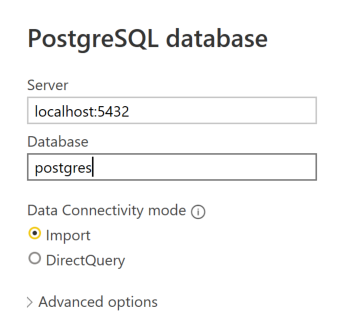

Notice we have two options for data connectivity mode:
* import: Power BI will take a snapshot of the data and cache it. Every time you filter or run another query it will be done against this cache.
* direct query: no data will be cached and every operation will be done against the DB. 

It is important to consider the implications in performance when choosing connectivity, especially when working with large datasets. 

You can now select all tables and go to 'Transform data'.

Take a moment to familiarize yourself with the options. On the left, you have the data tables, on centre the data and on the rigth you can see all the steps that have been applied to transform the data. As you keep on working on the data (filtering rows or columns, changing data types, etc.), each transformation is a step that will be added to that list. Remember that if something does not do what you expected it would do, you can always remove it from the 'Applied Steps' menu. 

Next you should verify that the data types are correct, going through each column the 'Data type' option will change. Make sure the types are what you expect them to be, and if the are not update them.

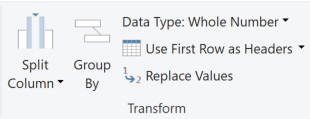

Once you are satisfied with the result, hit 'Close & apply'.


## Visualize, filter and limitations in the UI
Again, spend some time familiarizing yourself with the environment. In Power BI, we prepare reports, reports can have multiple pages and each page can have multiple visualizations.

Let us start by adding a 'Table' visualization by clicking on that 'Visualizations' menu. You can add fields from the same table by clicking on them, but notice that if you add fields from different tables the tool will do the join for you.  

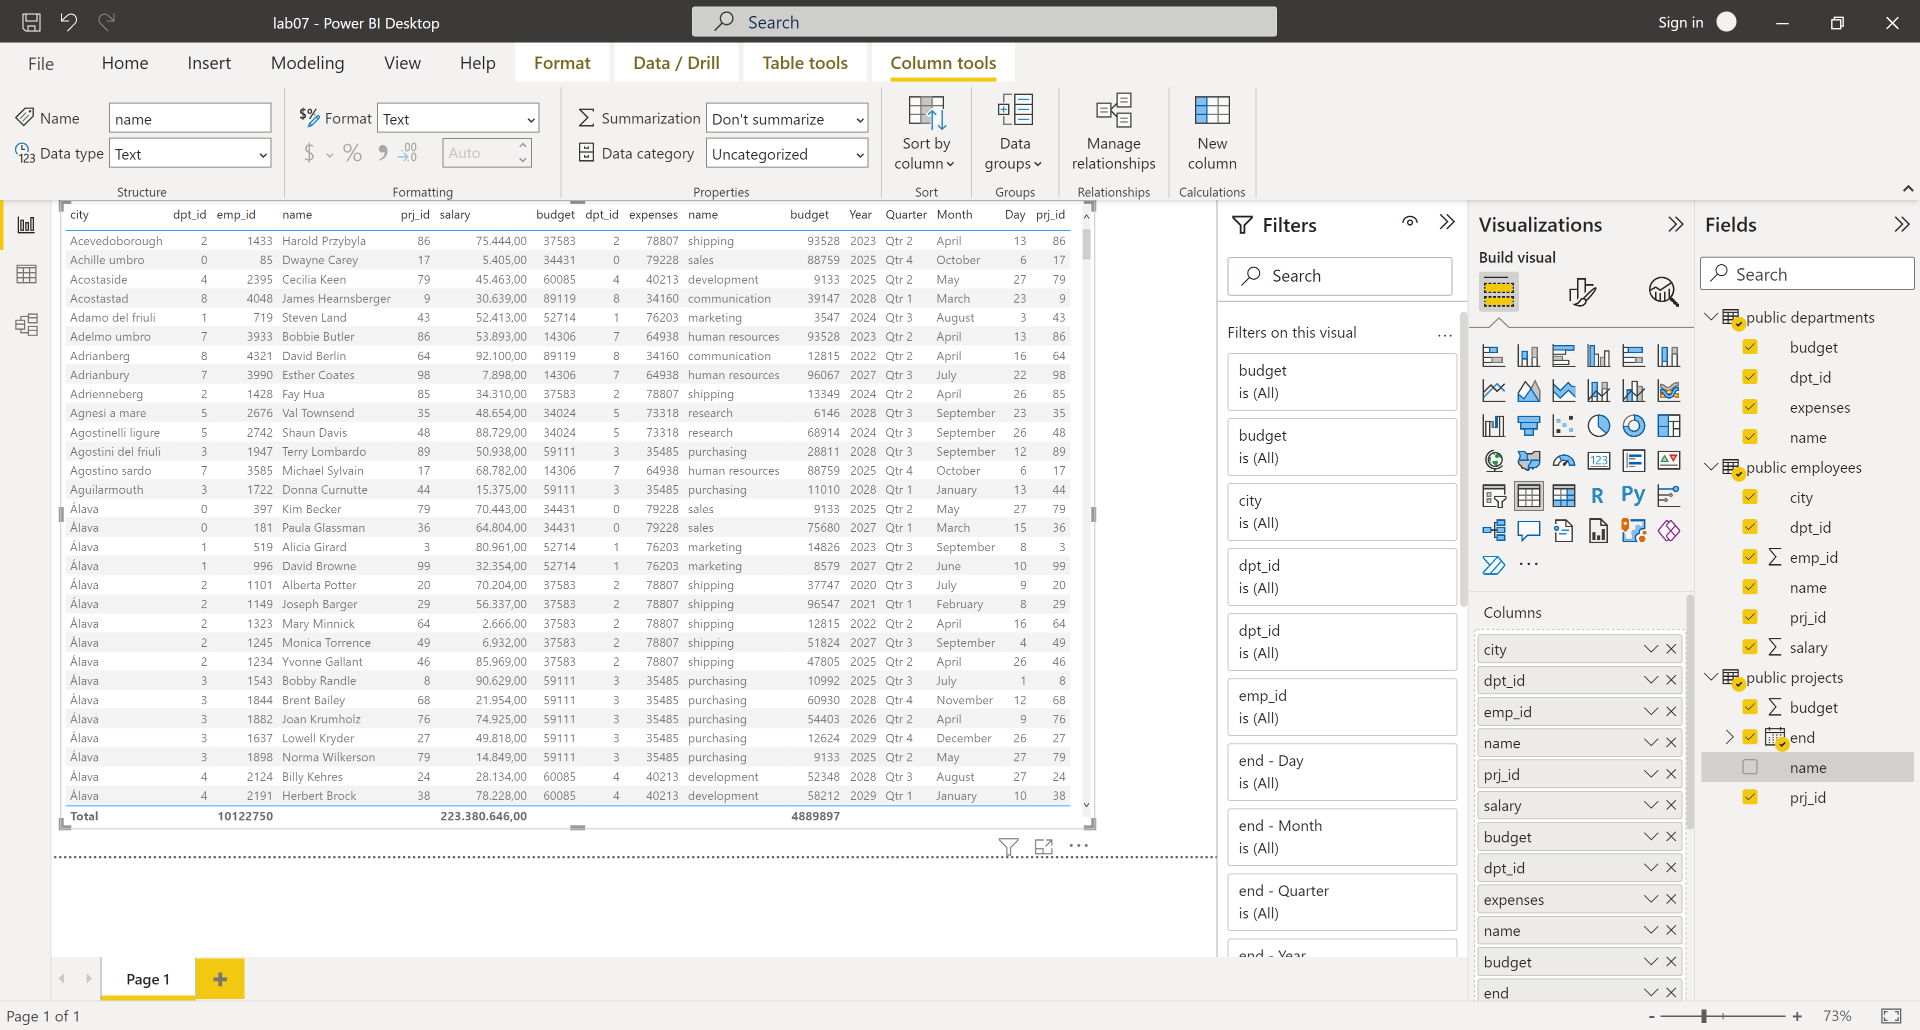

* Filter by condition: we can use the UI to set a filter on a field, for example, to get name and city of the employees with a salary higher than 70k. 

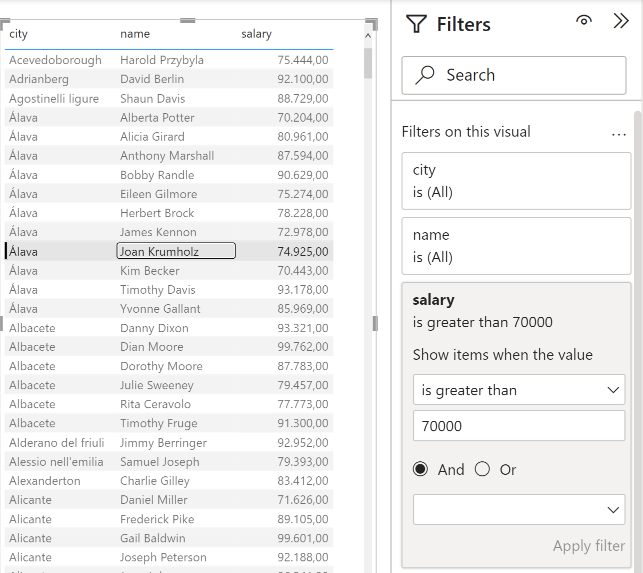

* Combination of filters: we can combine filters on different fields to get the employees with dpt_id different than 0, with a city starting with M or equal to Palencia, Cookton or Rachelburg, with name not null and salary between 50k and 60k).

By default, the UI will only allow you to specify at most 2 conditions in 'Advanced filtering'. We can fix that by going into 'Basic filtering' and selecting as many items as conditions you will need in 'Advanced filtering'. For example:

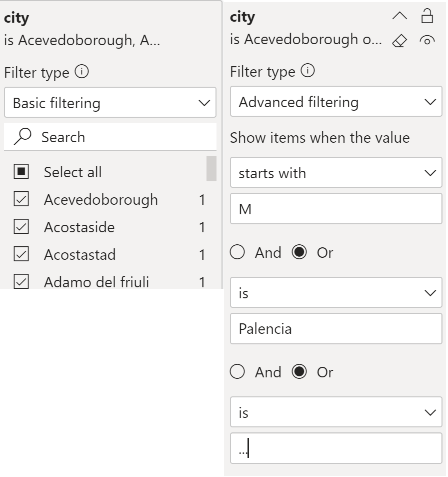

All combined (city filter shortened for convenience of representation):

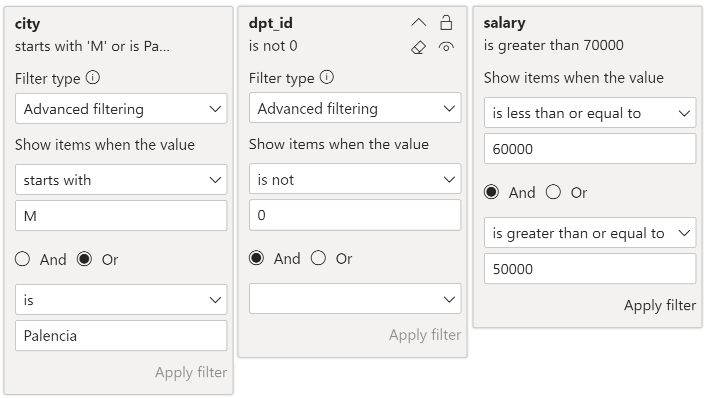

* Get all the different cities: add a table visualization and select the 'city' field. Power BI will only show unique elements.

Unfortunately, at some point we will encounter a scenario the UI does not cover. For example, selecting all employees with dpt_id == 1 OR having a city == Cookton. In those, we will need to use a scripting language like DAX (Data Analysis Expressions).


## DAX scripting
We will cover its syntax through examples. Go to the 'Modeling' menu and from there 'New table'; this will automatically take you to 'Table tools'.

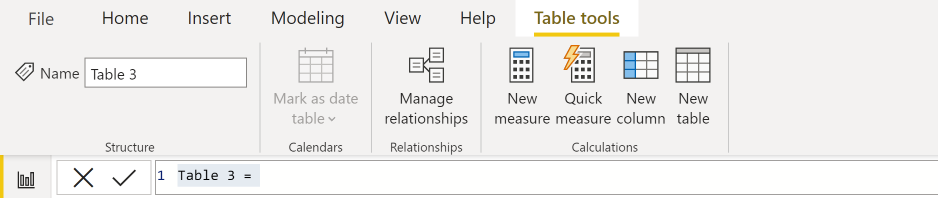

In this box you can query the data and store the result in a variable. For example: 

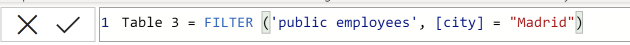

This will create a new dataset by applying a Filter over the 'employees' table and store the result in the 'Fields' area (more information on filter functions [here](https://docs.microsoft.com/en-us/dax/filter-functions-dax)). You can try visualizing the the query in a table.

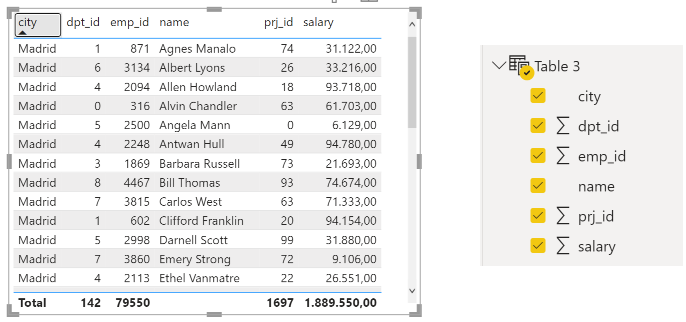

If at any given point you want to edit the query behind a dataset, you can just go to the 'Fields' area and click on the name of the table.

#### A quick note on summarisation
In the previous example, try unselecting the 'name' field. This will cause Power BI to summarise the data, which in some cases can be useful, like the summary of salaries in the city, or utterly meaningless, like the sum of 'dpt_id'.

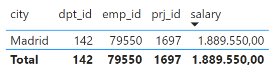

We can change the summarisation method in the 'Visualizations' area, by going into the field we want to edit in 'Columns' and setting it to 'Don't summarise' or one of the other options that may fit the dataset we are describing.

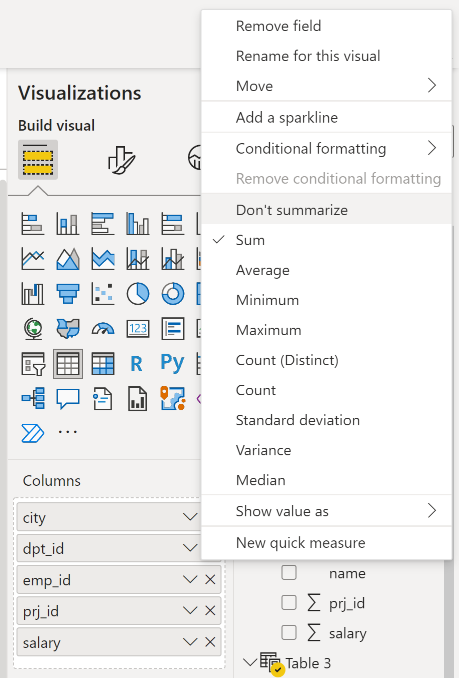

To fix this at the data level (you can select the field and change the 'Summarisation' method in the 'Column tools' area.

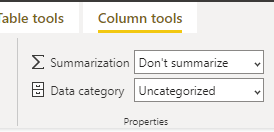


#### Multiple condition filters (AND, OR, NOT)
* In 'employees', find rows where 'city' is Madrid or Alicante or 'dpt_id' is 1:
```
Table 2 = FILTER ('public employees', [city] = "Madrid" || [city] = "Alicante" || [dpt_id] = 1)
```

We can also use the IN operator:
```
Table 2 = FILTER ('public employees', [city] IN {"Madrid", "Alicante"} || [dpt_id] = 1)
```

* In 'employees', find rows where 'city' is Madrid and 'dpt_id' is 1:
```
Table 2 = FILTER ('public employees', [city] = "Madrid" && [dpt_id] = 1)
```

* In 'employees', find rows where 'city' is Madrid or Alicante, and 'dpt_id' is 1:
```
Table 2 = FILTER ('public employees', ([city] = "Madrid" || [city] = "Alicante" ) && [dpt_id] = 1)
```

* In 'employees', find rows where 'city' is Madrid or something other than Alicante, and 'dpt_id' is 1:
```
Table 2 = FILTER ('public employees', ([city] = "Madrid" || [city] <> "Alicante" ) && [dpt_id] = 1)
```


#### Range query (across tables)
Let us find the people that work in departments with 78k < expenses < 79k:

We can start by creating a new table from departments:

```
Table 3 = FILTER ('public departments', [expenses] >= 78000 && [expenses] <= 79000)
```

Then, we need to define the relationship between 'employees' and this new table. Go to 'Modeling' -> 'Manage relationships', select 'New' and create a relationship from 'employees' to 'Table 3'. 

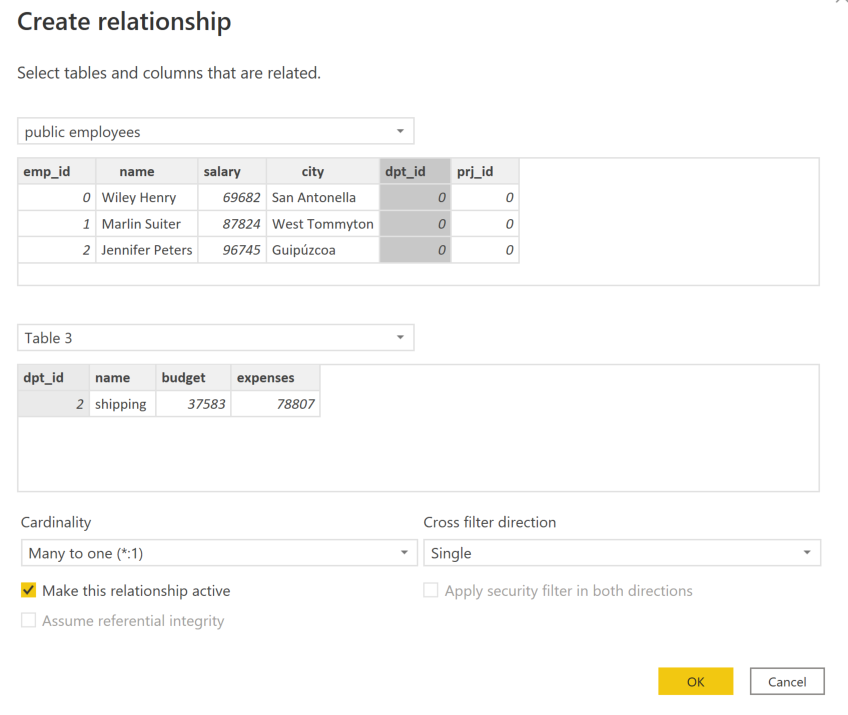

Next, create a table visualization and add the data you want from 'employees' plus 'expenses' from 'Table 3'. 
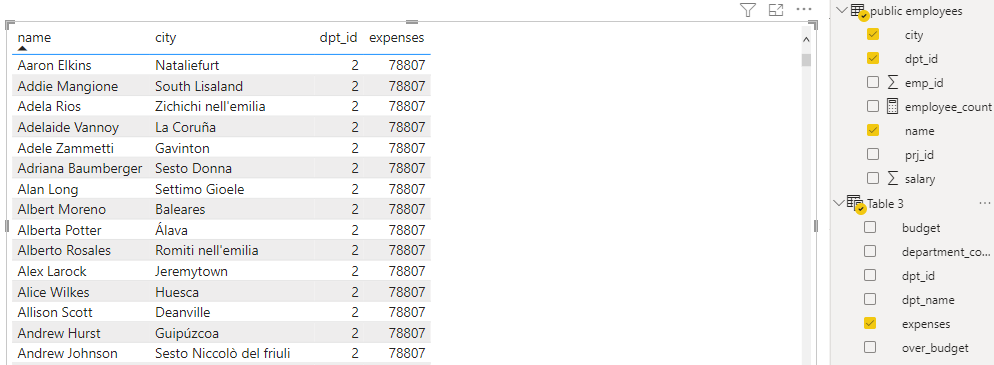

Finally, we can create a filter that selects the samples that have a 'expenses' field that is not blank. 

A more straightforward, and preferred, alternative is to use the RELATED function to filter the data in the query. Basically, RELATED uses an already defined relationship between the tables and allows us to combine conditions on fields belonging to different tables.

```
Table 4 = FILTER('public employees', RELATED('public departments'[expenses]) > 78000  && RELATED('public departments'[expenses]) < 79000)
```


#### Adding new features
Power BI also allows us to add new columns to the data. For example, if we wanted to know which departments are running over budget, we would select 'departments' in the 'Fields' area and then 'New column'. This will allow us to give the expression for the new column, in our case:
```
over_budget = IF('public departments'[budget] - 'public departments'[expenses] < 0, TRUE, FALSE)
```

#### Building a table
We can create a simple table with one column and 4 rows just by doing:
```
simple_table = {1,2,3,4}
```

Or we can create do the transpose with:
```
simple_table = {(1,2,3,4)}
```

Something to be mindful of is that Power BI will name your columns "Value1", "Value2", ... and that it will try to aggregate the values; we can fix both in the UI afterwards.

While you may be able to replace those scalar values with an expression, you are limited to expressions that evaluate to a single value, i.e., as you will see in the example below, you can do {(COUNT..., AVERAGE...)} because they return a single value but you cannot build tables like this by chaining columns. 

### Aggregation functions
SUM, DISTINCTCOUNT, COUNT, MIN, MAX, AVERAGE can be applied to summarise results (see the docs for a complete list <https://docs.microsoft.com/en-us/dax/aggregation-functions-dax>).

* Count the number of different cities employees live in and what is the employees average salary:

```
simple_aggr = {(DISTINCTCOUNT('public employees'[city]), AVERAGE('public employees'[salary]))}
```

### Summarize - grouping
Aggregation by field can be done through the UI, adding a new column to the already existing data or with DAX. 

For example, how many people work in every city? 

* In the UI we would create a new table visualization and select the 'city' column to add the data. Then, we would right click on 'city', select 'new measure' and define the expression: 
```
employee_count = COUNT('public employees'[city])
``` 
Then, we can select the new field to add it to the table. 


* With DAX, we would create a new table using the SUMMARIZE function:
```
Table 5 = SUMMARIZE('public employees', [city], "employee_count", COUNT('public employees'[city]))
```

What if we needed to count how many employees per department?
```
Table 5 = SUMMARIZE('public employees', [dpt_id], "count", COUNT('public employees'[dpt_id]))
```

Notice that the query results in this table, because Power BI tries to aggregate 'dpt_id' by default:
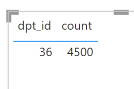

Be mindful of this, if you see something amiss, check whether the data is being aggregated in the 'Columns' area in 'Visualizations'. 

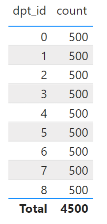

Now, this is not very meaningful, instead of counting by IDs we will try to count by department name.
* UI: add a new column to 'departments' that counts how many employees per department
```
department_count = COUNTROWS(RELATEDTABLE('public employees'))
```
* DAX:
```
Table 6 = SUMMARIZE('public departments', [name], "count", COUNTROWS(RELATEDTABLE('public employees')))
```

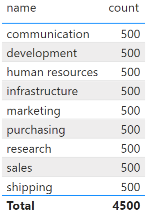



Here we just introduced two new functions:
* COUNTROWS: accepts an expression that evaluates to a table and counts its rows. It returns an integer number, it can be used to create new measures or in aggregations.
* RELATEDTABLE: remember that one employee works in one department but a department can have multiple employees. RELATED can bring values from One to the Many side of the realtionship (from Department into Employee) and RELATEDTABLE does the opposite (from Employee into Department). Since we wanted to show the name of the departments, and group by it, we needed to start in the 'departments' table and navigate from there.

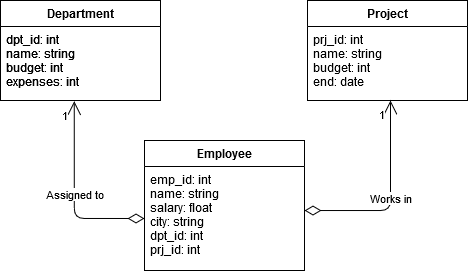



### Aggregate and filter
Aggregation combined with a query to filter out data, e.g., departments that start with 'd':
```
Table 7 = FILTER(SUMMARIZE('public departments', [name], "count", COUNTROWS(RELATEDTABLE('public employees'))),  LEFT([name], 1) = "d")
```
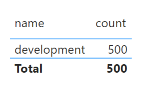

There is no option to order the results returned, since we are working with a dataset. However, we can sort within the visualization we create by clicking on the column name.

Another example would be, of the projects with budget greater than 50k, for every city, compute the average budget and the max budget.

First, let us do this in several steps:
* Compute the avg in a new table. Notice the use of CALCULATE to do aggregation and filtering at the same time:
```
avg-project-budget-table = SUMMARIZE('public employees', [city], "avg-project-budget", CALCULATE(AVERAGE('public projects'[budget]), 'public projects'[budget] >= 50000))
```
* Compute the max:
```
max-project-budget-table = SUMMARIZE('public employees', [city], "max-project-budget", CALCULATE(MAX('public projects'[budget]), 'public projects'[budget] >= 50000))
```
* Establish a relationship between the two tables based on city.
* Create a new visualization with fields from both (optionally, you can set up a filter to avoid displaying blank values with 'is not blank').
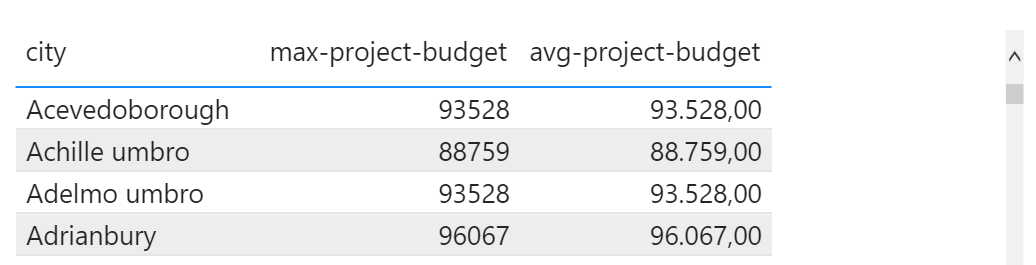


For the record, we could have done this in one operation with NATURALLEFTOUTERJOIN, which will join to tables on a column with the same name, provided they come from the same origin table (in this case 'employees').

```
avg_max_combined_table = 
    NATURALLEFTOUTERJOIN(
        SUMMARIZE('public employees', [city], "avg-project-budget", CALCULATE(AVERAGE('public projects'[budget]), 'public projects'[budget] >= 50000)), 
        SUMMARIZE('public employees', [city], "max-project-budget", CALCULATE(MAX('public projects'[budget]), 'public projects'[budget] >= 50000)))
```

## Exercise
We will be working with the same dataset and questions we dealt with in the previous lab, so that you have some reference to work on (and check if your results match).

We will use the [Adult UCI dataset](https://archive.ics.uci.edu/ml/datasets/adult) with a few modifications; download the following files: [description](./files/adults/adults.names), [data - part1](./files/adults/adults1.csv) [data - part2](./files/adults/adults2.csv).

Follow the instructions below and answer the questions. 

Filtering and joins should be done in DAX, not in the UI. You should submit the PowerBI file plus a Jupyter Notebook including the DAX code for each question and a snapshot of the visualization. 

1-2 are the same instructions you followed for the Postgres lab, they are reproduced here for your convenience.

1. Create the two tables in the DB with the right data dypes. In order to use enumerated types in the table definition you will first need to create the type. For example:

```
CREATE TYPE mood AS ENUM ('sad', 'ok', 'happy');
CREATE TABLE person (
    name text,
    current_mood mood
);
INSERT INTO person VALUES ('Moe', 'happy');
SELECT * FROM person WHERE current_mood = 'happy';
 name | current_mood 
------+--------------
 Moe  | happy
```

Notice that each row/sample does not have an id. Instead of using an INTEGER data type for the id, we recommend you look into SERIAL.

2. Load the datasets. We should use this version of the copy_from command where we specify the name of the columns and the value for NULL in the file of origin. Notice how we are not specifying the id column, since that will be autogenerated by the DB. Caveat: once you have loaded the data, double check that the id/SERIAL column starts at 1. 
```
cursor.copy_from(f, 'adults1', columns=('age', 'workclass', ...), sep=',', null='?')
```
3. How many people under 18 years old have never worked? Of the never having worked people (all ages) is there any race bias (how many by race)? Is there any sex bias?
4. Look at the hours per week of people with a paying job, by sex. Look at how many's income is above and below 50k. Compare and analyse.
5. How many people with college education do manual labour?
6. What is the minimum, mean and maximum capital gain and capital loss for every marital status?